# Introduction to empirical Bayes (with rat tumour example)

In this post, I will introduce the empirical Bayes method. The method is useful when working with problems where you have to estimate a lot of similar quantities. For example, say you wanted to find the best baseball player of all time. One simple (too simple, but this is just for illustration) approach would be to rank the players by their batting average. However, doing so would likely reveal that the players with the highest batting average are those who only got one or two plate appearances in their career and were lucky to get hits. The empirical Bayes method makes it possible to get more realistic estimates of the batting average by incorporating the evidence of all other recorded at bats.

On his blog, [varianceexplained.org](http://varianceexplained.org), David Robinson has an excellent [series of posts](http://varianceexplained.org/r/simulation-bayes-baseball/) where he explores the empirical Bayes method using Baseball statistics. In this post, I will also explore the empirical Bayes method, but using the rat tumour data from Chapter 5 of [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/) by Gelman et al.

## Data

Below is posted data collected in 71 experiments, which records the occurrence of a specific type of tumours observed in female lab rats. Each experiment records two quantities: the total number of rats that were examined in the experiment, $n_i$, and the number of rats that were found to have a tumour of the specified type, $y_i$.

In [1]:
%matplotlib inline
import pandas as pd

# Data from Gelman et al.
# Original data from Tarone (1982)
# Number of rats with tumours in each experiment
y = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 5, 2, 5, 2, \
     7, 7, 3, 3, 2, 9, 10, 4, 4, 4, 4, 4, 4, 4, 10, 4, 4, 4, 5, 11, 12, 5, 5, 6, 5, 6, 6, 6, 6, 16, 15, 15, 9, 4]
# Total number of rats in each experiment
n = [20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20, 20, 19, 19, 18, 18, 27, 25, 24, 23, 20, 20, \
     20, 20, 20, 20, 10, 49, 19, 46, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20, 48, 19, 19, 19, 22, \
     46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46, 47, 24, 14]

df = pd.DataFrame({'y':y, 'n':n})

Suppose we aim to estimate the probability, $\theta$, of a female lab rat developing a tumour. We can get a raw estimate of the tumour probability for each experiment by calculating the average $y_i/n_i$.

Text(0.5, 1.0, 'Distribution of raw tumour probabilities')

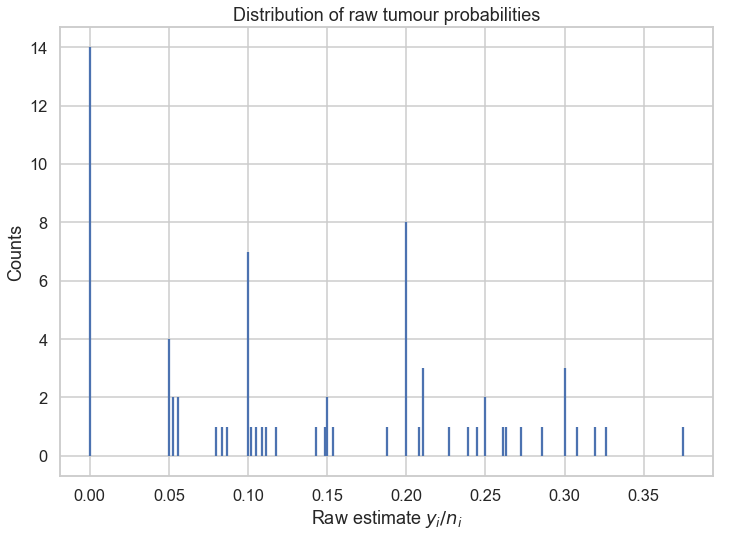

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid")
sns.set_context("talk")

# add raw probabilities to data frame
df["theta_raw"] = df.y/df.n

# count raw probabilities 
theta_counts = df['theta_raw'].value_counts()

plt.vlines(theta_counts.index.values, np.zeros(theta_counts.size), theta_counts.values, color='C0')
plt.xlabel(r"Raw estimate $y_i/n_i$")
plt.ylabel("Counts")
plt.title("Distribution of raw tumour probabilities")

Plotting the raw probabilities, we see that the estimate for each experiment range between 0 and 0.375. Can these estimates be improved? Sure, for example it seems implausible that the true tumour probability is exactly 0 in 14 of the experiments. On the other hand, the variability between the individual estimates is large enough that it also seems improbable that the true tumour probability is the same in all 71 experiments.

## Bayes Theorem

The theoretical foundation behind the empirical Bayes method is Bayes Theorem, which looks like this

$$
p(\theta \mid y, n) = \frac{p(\theta) \times p(y \mid \theta, n)}{p(y)}
$$

$p(y \mid \theta)$ is the *likelihood* and is the probability of the data assuming the parameter, $\theta$ is known. For data that records a binary variable (like in this example) the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) is typically used as the likelihood

$$
p(y \mid \theta, n) = \mathrm{Binomial}(n, \theta) = \binom{n}{y} \theta^y \, (1 - \theta)^{n - y}
$$

where $n$, in this example, is the number of rats in the experiment.

$p(\theta)$ is the *prior* probability distribution. In cases with a binomial likelihood it is convenient to use a [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) as prior

$$
p(\theta) = \mathrm{Beta}(\alpha, \beta) = \frac{\theta^{\alpha-1} \, (1-\theta)^{\beta-1}}{B(\alpha, \beta)}
$$

where $B(\alpha, \beta)$ is the [beta function](https://en.wikipedia.org/wiki/Beta_function), and $\alpha$ and $\beta$ are the the two shape parameters of the distribution. Roughly speaking, the beta distribution can be interpreted as a distribution of the most likely probability, $\theta$, for a binomial process with $\alpha$ successes and $\beta$ failures (I also strongly recommend [this post](http://varianceexplained.org/statistics/beta_distribution_and_baseball/) from David Robinson's blog on understanding the beta distribution).

The beta distribution is convenient to use as prior in conjunction with a binomial likelihood because it ensures that the *posterior* probability distribution, $p(\theta \mid y)$ is also a beta distribution. For a beta prior and a binomial likelihood the posterior probability is

$$
p(\theta \mid y, n) = \mathrm{Beta}(\alpha+y, n-y+\beta) = \frac{\theta^{y+\alpha-1} \, (1-\theta)^{n-y+\beta-1}}{B(y+\alpha, n-y+\beta)}
$$

## Empirical Bayes method

Conceptually, the empirical Bayes method can be split into two steps

1. Estimate the prior probability distribution, $p(\theta)$, from the data
2. Use the estimated prior to infer the posterior probability distribution, $p(\theta \mid y)$

### Estimating the prior probability, $p(\theta)$

For the example at hand, estimating the prior probability means finding the values of the parameters $\alpha$ and $\beta$ of the beta distribution that best matches our data. There are several ways of doing this but the most rigorous is to fit a [beta-binomial distribution](https://en.wikipedia.org/wiki/Beta-binomial_distribution) to the data. The beta-binomial distribution is the binomial distribution in which the probability of success at each trial is fixed but randomly drawn from a beta distribution prior.

The beta-binomial distribution is written as

$$
p(\alpha, \beta \mid y, n) = \binom{n}{y} \frac{B(y+\alpha, n-y+\beta)}{B(\alpha, \beta)}
$$

and the optimal values of $\alpha$ and $\beta$ can be found as 

$$
\underset{\alpha,\beta}{\mathrm{arg\,max}}\prod_i p(\alpha, \beta \mid y_i, n_i)
$$

It is often convenient to work in log-space where the product becomes a sum to avoid float-precision issues. Also, most optimisation functions minimise instead of maximise, and so the problem can instead be formulated in terms of a *loss function*

$$
\mathcal{L}(\alpha, \beta) = \underset{\alpha,\beta}{\mathrm{arg\,min}}-\sum_i \log p(\alpha, \beta \mid y_i, n_i)
$$

In [3]:
from scipy.special import gammaln
from scipy.optimize import minimize

def beta_function(alpha, beta, log=True):
    log_beta = gammaln(alpha) + gammaln(beta) - gammaln(alpha+beta)
    
    if log:
        return log_beta
    else:
        return np.exp(log_beta)

def beta_binomial_distribution(k, n, alpha, beta, log=True):
    log_beta_binomial = gammaln(n+1) - gammaln(k+1) - gammaln(n-k+1) + \
                        beta_function(k+alpha, n-k+beta, log=True) - beta_function(alpha, beta, log=True)
    
    if log:
        return log_beta_binomial
    else:
        return np.exp(log_beta_binomial)

# function to minimize
def loss_function(ab, k, n):
    alpha, beta = ab
    return -np.sum(beta_binomial_distribution(k, n, alpha, beta, log=True))

min_result = minimize(loss_function, [2, 2], args=(df.y.values, df.n.values), method="Nelder-Mead")
alpha0, beta0 = min_result['x']

print("Estimated alpha parameter = {}".format(alpha0))
print("Estimated beta parameter  = {}".format(beta0))

Estimated alpha parameter = 2.3416074415106394
Estimated beta parameter  = 14.114759575657441


For the rat tumour data, the values of the $\alpha$ and $\beta$ parameters that minimises the loss function are

$$
\begin{eqnarray}
\alpha_0 &=& 2.34 \\
\beta_0 &=& 14.1
\end{eqnarray}
$$

The quantity $\alpha_0/(\alpha_0+\beta_0) = 0.142$ is the average probability of the prior distribution. The quantity $\alpha_0+\beta_0 = 16.5$ can be understood as the "sample size" of the prior distribution. The larger the sum of $\alpha$ and $\beta$ the narrower will the distribution become.

Below, I plot the prior distribution $p(\theta)$ that corresponds to these parameters, along with the raw tumour probabilities from above

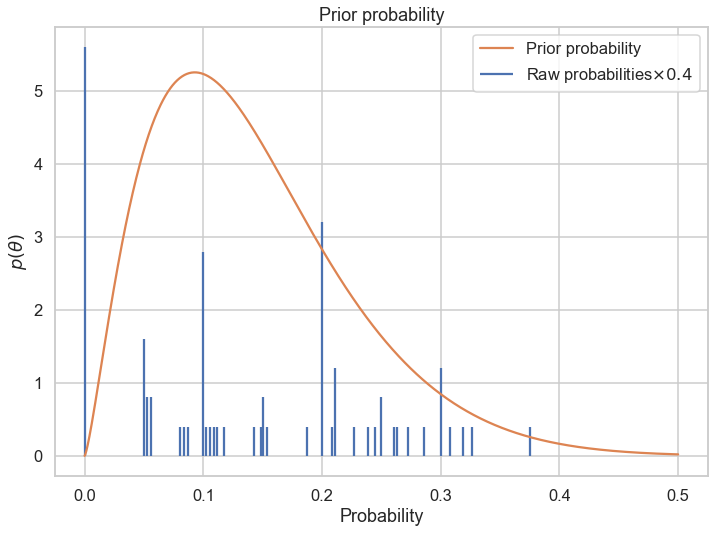

In [4]:
from scipy.stats import beta

prior = beta(alpha0, beta0)

x = np.linspace(0, 0.5, 1000)

plt.vlines(theta_counts.index.values, np.zeros(theta_counts.size), 0.4*theta_counts.values,
           color='C0', label=r"Raw probabilities$\times 0.4$")
plt.plot(x, prior.pdf(x), color='C1', label=r"Prior probability")
plt.title(r"Prior probability")
plt.ylabel(r"$p(\theta)$")
plt.xlabel(r"Probability")
plt.legend()

The prior distribution covers the entire range of the raw probabilities with the "meaty" part of the distribution centered around the highest concentration of raw probabilities, as we would expect for a distribution estimated from the data.

### Inferring the posterior distribution, $p(\theta \mid y, n)$

Now that we have gotten an estimate of the prior distribution, inferring the posterior distribution for each experiment is incredibly simple

$$
p(\theta_i \mid y_i, n_i) = \mathrm{Beta}(\alpha_0+y_i, n_i-y_i+\beta_i) = \frac{\theta_i^{y_i+\alpha_0-1} \, (1-\theta_i)^{n_i-y_i+\beta_0-1}}{B(y_i+\alpha_0, n_i-y_i+\beta_0)}
$$

Below I plot the posterior distribution for three of the experiments along with the prior distribution.

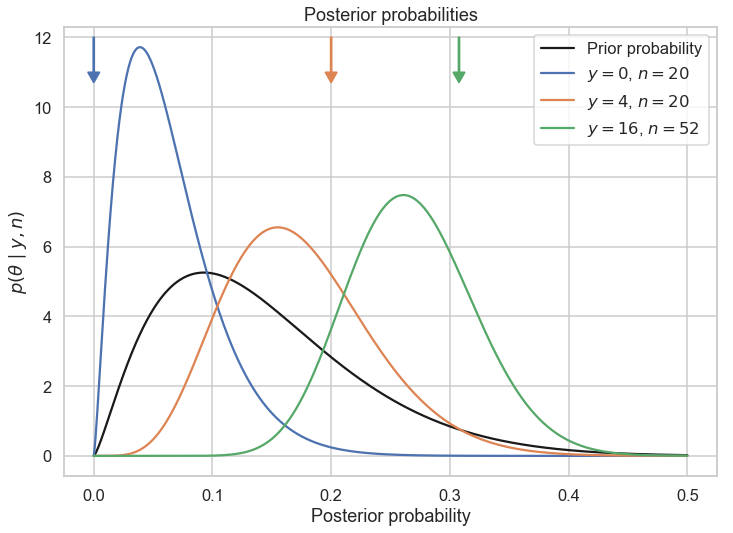

In [5]:
x = np.linspace(0, 0.5, num=1000)

#prior probability
plt.plot(x,prior.pdf(x), color='k', label=r"Prior probability")
#posterior probabilities
plt.plot(x, beta(alpha0+0, beta0+20-0).pdf(x), label=r"$y=0$, $n=20$")
plt.plot(x, beta(alpha0+4, beta0+20-4).pdf(x), label="$y=4$, $n=20$")
plt.plot(x, beta(alpha0+16, beta0+52-16).pdf(x), label="$y=16$, $n=52$")
#raw probabilities
plt.arrow(0/20, 12, 0, -1, head_width=0.01, head_length=0.3, ec='C0', fc='C0')
plt.arrow(4/20, 12, 0, -1, head_width=0.01, head_length=0.3, ec='C1', fc='C1')
plt.arrow(16/52, 12, 0, -1, head_width=0.01, head_length=0.3, ec='C2', fc='C2')

plt.title(r"Posterior probabilities")
plt.ylabel(r"$p(\theta \mid y, n)$")
plt.xlabel(r"Posterior probability")
plt.legend()

The three arrows show the raw probability estimate, $y_i/n_i$ for each of the three experiments. In each case, we see that the posterior distribution has been shifted away from the raw estimate and towards the average of the prior. How much the distribution will be shifted will depend on how close the raw estimate already was to the prior average -estimates close to the prior average will not be shifted as much - and the size of the sample for the experiment - larger samples will be shifted less.

Below is plotted the raw estimates for all the experiments vs. the posterior means with 95% credible intervals. The dashed line shows the diagonal. The individual points have been jittered to reduce overlap. The posterior estimates are *shrunk* towards the prior mean.

(-0.01, 0.4)

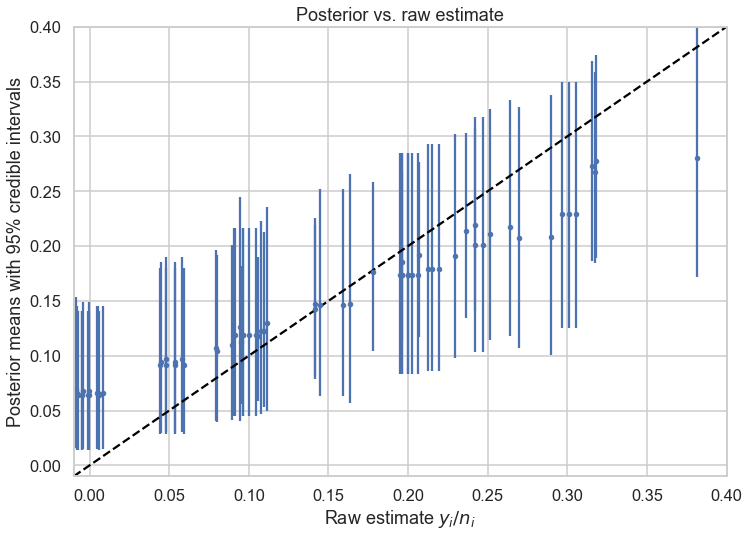

In [6]:
from numpy.random import uniform

posterior = beta(alpha0 + df.y.values, beta0 + df.n.values - df.y.values)

df["theta_mean"] = posterior.mean()
df["theta_ci_min"] = posterior.ppf(0.05)
df["theta_ci_max"] = posterior.ppf(0.95)
yerr = [df.theta_mean.values-df.theta_ci_min.values, df.theta_ci_max.values-df.theta_mean.values]

dx = 0.02
plt.plot([-dx/2, 1], [-dx/2, 1], color='black', linestyle='--')
plt.errorbar(df.theta_raw.values+uniform(size=71)*dx-dx/2, df.theta_mean.values, yerr=yerr, fmt='.')
plt.title("Posterior vs. raw estimate")
plt.ylabel("Posterior means with 95% credible intervals")
plt.xlabel(r"Raw estimate $y_i/n_i$")
plt.xlim(-dx/2, 0.4)
plt.ylim(-dx/2, 0.4)

## Conclusion

The empirical Bayes method is very simple to implement and use, and can give you significantly improved estimates for problems where there is a lot of repeated structure (such as repeated experiments). One may interject that estimating the prior probability directly from the data is not the correct Bayesian way handling the problem. A more rigorous approach would be use a hierarchical Bayesian model, which I plan to explore in a later post.